In [1]:
import numpy as np

import tensorflow as tf

import pylab
%matplotlib inline

In [2]:
X_data = np.loadtxt('./coordinates1.csv', delimiter='$').astype('float64')
X_data /= np.max(X_data)

Y_data = np.loadtxt('./data_genotypes1.csv', delimiter='$').astype('float64')

In [3]:
assert(len(X_data) == len(Y_data))

N = X_data.shape[0]
k = X_data.shape[1]
M = Y_data.shape[1]
Y_data[Y_data < 0.5] = -1.0

In [4]:
with tf.device('/cpu:0'):
    X = tf.Variable(dtype=tf.float64, initial_value=X_data, trainable=False)
    Y = tf.Variable(dtype=tf.float64, initial_value=Y_data, trainable=False)
    
    F = tf.Variable(dtype=tf.float64, initial_value=np.random.normal(0.0, 0.1, (N, M)).astype('float64'),
                    trainable=True)

    l = tf.placeholder(shape=[], dtype=tf.float64)
    a = tf.placeholder(shape=[], dtype=tf.float64)

    K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l), reduction_indices=[2])) + \
        0.0001 * tf.eye(N, dtype=tf.float64)

    p = tf.nn.sigmoid(F)
    Kinv_F = tf.matrix_solve(K, F)
    
    data_fit = -tf.reduce_sum(tf.log(1 + tf.exp(-Y * F)), reduction_indices=[0])
    prior_fit = -0.5 * tf.reduce_sum(F * Kinv_F, reduction_indices=[0])
    
    logL = tf.reduce_sum(data_fit + prior_fit)
    
    g =  (0.5 * (Y + 1) - p) - Kinv_F
    
    W = p * (1 - p)
    lhs = -K[:, :, None] * W[None, :, :] - tf.eye(N, dtype=tf.float64)[:, :, None]
    rhs = tf.matmul(K, g)
    
    update = tf.matrix_solve(tf.transpose(lhs, [2, 0, 1]), tf.transpose(rhs, [1, 0])[:, :, None])[:, :, 0]
    update = tf.transpose(update)
    
    opt_op = F.assign(F - update)
    
    #####
    
    B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + tf.eye(N, dtype=tf.float64)[:, :, None]
    det = tf.reduce_sum(tf.log(tf.matrix_diag_part(tf.cholesky(tf.transpose(B, [2, 0, 1])))))
    
    margL = logL - det

In [5]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.01

In [11]:
a_list = 0.01 * 2 ** np.arange(10)
l_list = 0.001 * 2 ** np.arange(10)

res = []

with tf.Session(config=config) as sess:
    
    for aa in a_list:
        for ll in l_list:
    
            sess.run(tf.initialize_all_variables())

            prev = None
            for i in range(20):
                r = sess.run([opt_op, update, logL, margL], {a: aa, l:ll})
                if prev and np.abs(prev - r[-1]) < 0.01:
                    break
                prev = r[-1]
            
            res.append(r[-1])

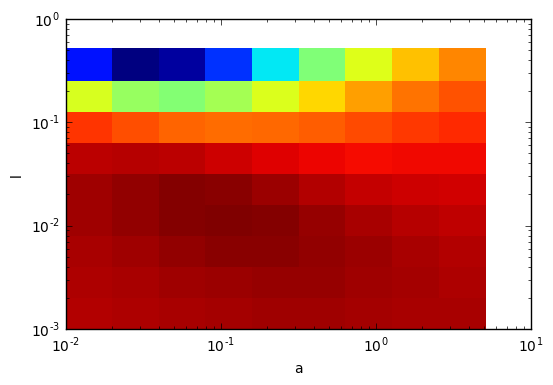

In [18]:
surface = np.array(res).reshape((10, 10))
pylab.pcolormesh(a_list, l_list, surface)
pylab.xscale('log')
pylab.yscale('log')
pylab.xlabel('a')
pylab.ylabel('l')

In [25]:
np.max(surface) / (N * np.log(2) * M)

-0.99742642499559919

In [33]:
with tf.Session(config=config) as sess:
    sess.run(tf.initialize_all_variables())
    for i in range(3):
        sess.run(opt_op, {a: 0.1, l:0.01})
    r = sess.run(F, {a: 0.1, l: 0.01})
    print(r)

[[-0.24373595 -0.0545596  -0.22419409 ..., -0.1735684  -0.04007622
   0.01667403]
 [-0.25001659 -0.05697588 -0.28202501 ..., -0.17966255 -0.05566548
   0.01034017]
 [-0.22651483 -0.03118542 -0.31736785 ..., -0.17535107 -0.06709491
   0.00240781]
 ..., 
 [-0.34625759  0.03027676  0.13141705 ...,  0.11592376 -0.08358974
   0.17164766]
 [-0.31298319 -0.0083094   0.11794772 ...,  0.12612358 -0.12891975
   0.11239384]
 [-0.2589873  -0.04222188  0.09869407 ...,  0.12795075 -0.14595392
   0.06265363]]


In [52]:
x, y, z = X_data[:, 0], X_data[:, 1], r[:, 0]

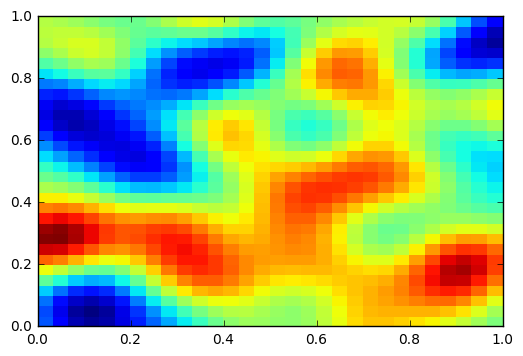

In [60]:
pylab.pcolormesh(x.reshape(31, 31), y.reshape(31, 31), z.reshape(31, 31))

In [42]:
x.shape

(961,)

In [43]:
y.shape

(961,)

In [54]:
z.shape

(961,)

In [55]:
961 ** 0.5

31.0